In [25]:
""" Comparison between  merged files (Leo) and new ones (Federico) """

import os,sys
import xarray as xr
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec

res_old = {}

dir_old = '/fio/srvx7/leo/fastscratch/ei6/001001/'

stat_001001 = ['001001/ERA5_1_001001_t.nc',
'001001/ERA5_2_001001_t.nc',
'1:1001/ERA5_1761_1:1001_t.nc',
'1:1001/ERA5_1759_1:1001_t.nc',
'001001/ERA5_erapresat_001001_t.nc',
'1:1001/ERA5_erapresat_1:1001_t.nc',
'001001/ERA5_igra_001001_t.nc' ]

merged_old = 'feedbackmerged001001_t.nc'

""" Loading newly merged files
lat
lon
alt
press array([  10.,   20.,   30.,   50.,   70.,  100.,  150.,  200.,  250.,  300., 400.,  500.,  700.,  850.,  925., 1000.]
datum len(d['datum'][0]) = 25891
hours [0,1]
temperatures shape: (2,16,25891)
era5_andep



to select plevels: [0,11,14,15] = [10,500,925,1000] [hPa]
to select hours: [0,1] = [00,12]  ??? maybe 

"""


""" Check if data was already extracted, if not extract it """
def extract_old_data(dir, filename):
        d = xr.open_dataset(dir_old + merged_old , engine = 'h5netcdf' , decode_times = True )
        datum = d['datum'].values[0]
        temp =  d['temperatures']
        
        press = d['press'].values
        d.close() 
        
        if not os.path.isfile(filename + '.pkl'):
                
                
                res_old = {}
                res_old['date_time'] = []
                res_old['press'] = []
                res_old['t'] = []
                #res_old['dep'] = [] # analysis departure
                for h in [0,1]:
                        if h ==0:
                            delta = np.timedelta64(0,'h')
                        else:
                            delta = np.timedelta64(12,'h')
                        #for p,press in  zip([0,11,14,15] , [10,500,925,1000]) :
                        for p,press in  zip([0,3,14,15] , [10, 50, 925, 1000]) :
                            
                            for i in tqdm(range(len(datum))):
                                # extract temp values
                                t = float(temp[h,p,i].values)
                                res_old['t'].append(t)
                                # extract dates values
                                
                                date = datum[i]
                                date = date + delta
                                res_old['date_time'].append(date)
                                
                                # extracts pressure
                                res_old['press'].append(press*100)
            
                df = pd.DataFrame.from_dict(res_old)
                q = pd.arrays.DatetimeArray( df['date_time'][:] )
                df['time'] = q 
                df['hour'] = q.hour
                    
                df.to_pickle(filename + '.pkl')
        else:
                df = pd.read_pickle( filename + '.pkl')
                
        #print("Loaded old merged file df")
        return df 


def extract_new_data(dir, filename):
        """ Loading newly merged/harvested files, encoded with CDM conventions.
              dir = database directory
              filename = filename """
        #print('Loading data from: ', filename )
        s = filename
        if not os.path.isfile(filename + '_merged.pkl'):
    
                f = dir + filename
    
                d = xr.open_dataset(f , engine = 'h5netcdf' , group = 'observations_table' , decode_times = True )
                
                a = {'date_time' :  pd.arrays.DatetimeArray ( d['date_time'].values) , 
                     'var': d['observed_variable'].values ,  'press': d['z_coordinate'].values ,
                     't':  d['observation_value'].values
                     }
                
            
            
                df = pd.DataFrame.from_dict(a)
                
                red = df.loc [ ( df ['press'] == 1000) | 
                                      ( df ['press'] == 5000) | 
                                      ( df ['press'] == 92500) | 
                                      ( df ['press'] == 100000) ]
                
                red = red.loc[red['var'] == 85]
                
                q = pd.arrays.DatetimeArray( red['date_time'][:] )
                if len(q) > 0:
                        
                        red['time'] = q 
                        red['hour'] = q.hour
                else:
                        a = np.full( (len(red['press'])) , np.nan )
                        red['hour'] = a
                        red['time'] = a
                
                red.to_pickle( filename + '_merged.pkl' )
                
        else:
                red = pd.read_pickle( filename + '_merged.pkl')
                
        #print("Loaded merged file df ", filename)
        return red 
    


def extract_data_from_df(df,p,h, which = 'old'):
        "Exract from the dataframe df he data for pressure , hour h, for old or new files "
        if which == 'old': # Leo files 
                """ Data from old file """
                old = df.loc [ (df['press'] == p) & (df['hour'] == h) ]
                time, temp = old['time'].values , old['t'].values                  
                
        elif which == 'new':
                """ Data from new file s1 """
                if h ==0:
                        n1 = df.loc [ (df['hour']  >= 22) | (df['hour']  <= 2)  ]
                        n1 = n1.loc[(n1['press'] == p) ]
                
                else:
                        n1 = df.loc [ (df['press'] == p) & (df['hour']  >= 10) & (df['hour']  <= 14)  ]
                        
                time, temp = n1['time'].values , n1['t'].values                
        else:
                print('ONLY SELECT which=new or which=old')
                return

        return time,temp
        
        
def plot_series_old_new (df_old, df_s1, df_s2):
        """ Plotting the extracted data.
              This one compares the global old and new data. """
                
        os.system('mkdir Plots')
        for p in [5000, 92500, 100000]:
                for h in [0,12]:
                        #print('Plotting: ' , p , ' ', h )
                        
                        """ Data from old file """
                        old_time, old_temp = extract_data_from_df(df_old, p, h, which = 'old')

                        """ Data from new file s1 """                            
                        n2_time, n2_temp = extract_data_from_df(df_s2, p, h, which = 'new')                 
                        n1_time, n1_temp = extract_data_from_df(df_s1, p, h, which = 'new')

                        """ Creating the plot """
                        plt.figure(figsize = (10,7))
                        
                        plt.scatter(old_time, old_temp, label = 'old merged', color = 'black', s=3)
                        plt.scatter(n2_time, n2_temp, label = '20000-0-01001', color = 'red', s=0.5)
                        plt.scatter(n1_time, n1_temp, label = '20001-0-01001', color = 'lime', s=1)
                        
                        plt.grid(ls=':' , color = 'lightgray')
                        
                        plt.ylabel('Temperature [K]')
                        if p == 5000:
                            plt.ylim(180,280)
                        else:
                            plt.ylim(240,340)

                        plt.title('Temperature time series , p=' + str(p) + ' , hour=' + str(h) )
                        plt.legend(fontsize = 8)
                        plt.savefig('Plots/global_press_' + str(p) + '_hour_' + str(h) + '.png' , dpi = 200 )
                        plt.show()
                        plt.close()
                        
                        print(0)
                        
                        
def plot_new_comparison (files, dirs):
        """ Plotting the extracted data """

        
        os.system('mkdir Plots')
        for p in [5000, 92500, 100000]:
                for h in [0,12]:
                        #print('Plotting: ' , p , ' ', h )
                        
                        #fig = plt.figure()
                        fig = plt.figure(constrained_layout = True, figsize=(10,10))
                        
                        #plt.title('Temperature time series comparison , p=' + str(p) + ' , hour=' + str(h) )                        
                        gs = gridspec.GridSpec(len(files), 1, figure = fig) # (number of rows, number of columns )
                        for f,d,index in zip(files,dirs, range(len(files))):
                                ax = fig.add_subplot(gs[index,:])
                                if index == 0:
                                        ax.set_title('Temperature time series comparison , p=' + str(p) + ' [Pa], hour=' + str(h),
                                                     color = 'red'  , y = 1.02 , fontsize = 14)
                                if 'feed' not in f:
                                        
                                        df = extract_new_data(d, f)
                                        time, temp = extract_data_from_df(df, p, h, which = 'new')    
                                else:
                                        df = extract_old_data(d, f)
                                        time, temp = extract_data_from_df(df, p, h, which = 'old')    
                                        
                                if 'era5_1761' in f:
                                        ax.scatter(time, temp, label = f +'(not used)' , s=1, color = 'lime')      
                                elif 'CEUAS' in f:
                                        ax.scatter(time, temp, label = f +'(db v1)' , s=1, color = 'blue')   
                                elif 'feed' in f:
                                        ax.scatter(time, temp, label = f +'(old)' , s=1, color = 'orange')   
                                        
                                else:
                                        ax.scatter(time, temp, label = f, s=1)
 
                                if 'feed' not in f:
                                        ax.xaxis.set_ticklabels([])
                                """ Global properties """
                                ax.legend(fontsize = 8 , loc = 'upper left')
                                if p ==5000:
                                    ax.set_ylim(180,260)
                                else:
                                    ax.set_ylim(240,320)

                                ax.set_xlim(np.datetime64('1940-01-01'), np.datetime64('2020-01-01'))                                
                                ax.tick_params(axis = 'both' , labelsize = 8)
                                ax.grid(ls=':' , color = 'lightgray')

                                
                        plt.savefig('Plots/allnewfilescomparison_press_' + str(p) + '_hour_' + str(h) + '.png' , dpi = 200 )
                        plt.show()
                        plt.close()
                        
                        print(0)        
                
                
                
                
""" First lobal comparison plot """               

dir_new = '/raid60/scratch/federico/DATABASE_JANUARY2021_FIXED_sensor/' 
merged_new = ['0-20000-0-01001_CEUAS_merged_v0.nc' , '0-20001-0-01001_CEUAS_merged_v0.nc' , ]

dir_old = '/fio/srvx7/leo/fastscratch/ei6/001001/'

stat_001001 = ['001001/ERA5_1_001001_t.nc',
'001001/ERA5_2_001001_t.nc',
'1:1001/ERA5_1761_1:1001_t.nc',
'1:1001/ERA5_1759_1:1001_t.nc',
'001001/ERA5_erapresat_001001_t.nc',
'1:1001/ERA5_erapresat_1:1001_t.nc',
'001001/ERA5_igra_001001_t.nc' ]

merged_old = 'feedbackmerged001001_t.nc'

remove_pickle = True
if remove_pickle:
    for a in [s for s in os.listdir('.') if '.pkl' in s]:
        os.system('rm ' + a )
        
        

print('Extracting new data')
df_old = extract_old_data(dir_old, merged_old )
print('Extracting old data')
df_s1= extract_new_data(dir_new, merged_new[0] )
df_s2 = extract_new_data(dir_new, merged_new[1] )
                        
#a = plot_series_old_new(df_old, df_s1, df_s2)





""" Analyse each single input file """
dir_new = '/raid60/scratch/federico/DATABASE_JANUARY2021_FIXED_sensor/' 
a = xr.open_dataset(dir_new+'0-20000-0-01001_CEUAS_merged_v0.nc' , engine = 'h5netcdf' , group = 'source_configuration' , decode_times = True )

harvested_dir = '/raid60/scratch/federico/HARVESTED_JAN2021/'

# creating the list of input file form the merged file
files_list = [ f.decode('utf-8') for f in set(a['source_file'].values) ]
dirs = [harvested_dir + f.split('_harvested')[0].replace(f.split('_')[0]+'_','') + '/'  for f in files_list ] # extract harvested path form file name list 

files_list.append('0-20000-0-01001_era5_1761_harvested_era5.1761.conv._1:1001.gz.nc')
dirs.append('/raid60/scratch/federico/HARVESTED_JAN2021/era5_1761/')

#adding the new CEUAS v1 merged file
files_list.append('0-20000-0-01001_CEUAS_merged_v0.nc' )
dirs.append(dir_new)

#adding the old merged file
files_list.append(merged_old)
dirs.append(dir_old)

  0%|          | 0/25891 [00:00<?, ?it/s]

Extracting new data


100%|██████████| 25891/25891 [00:13<00:00, 1927.58it/s]


Extracting old data


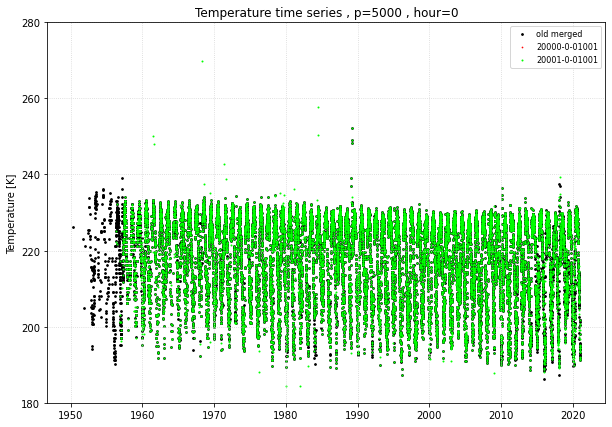

0


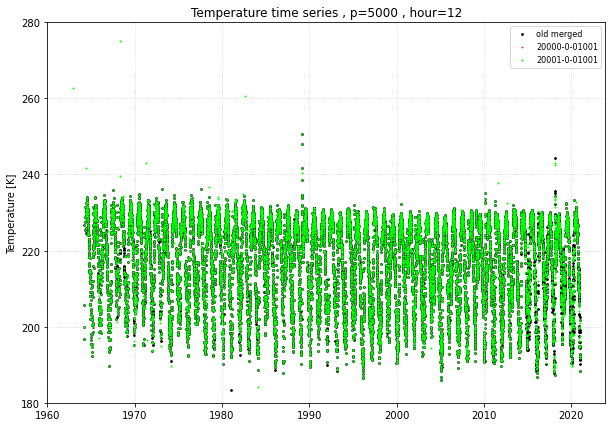

0


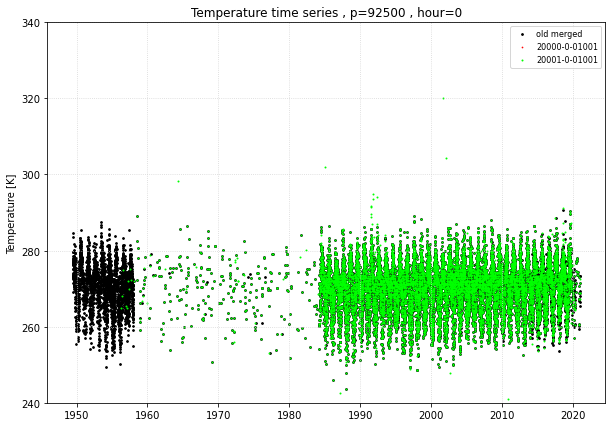

0


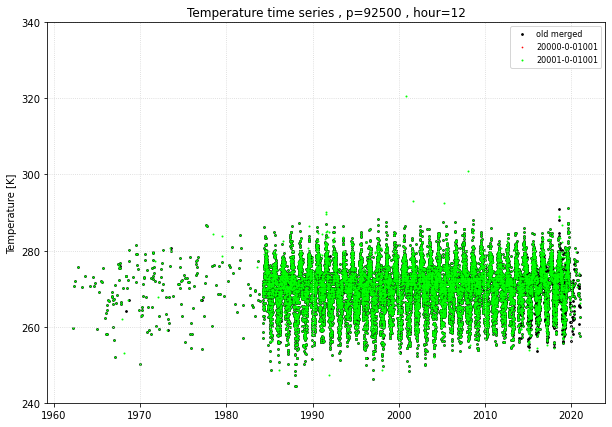

0


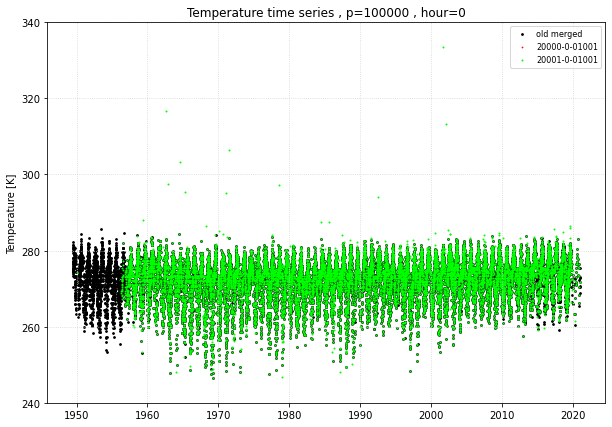

0


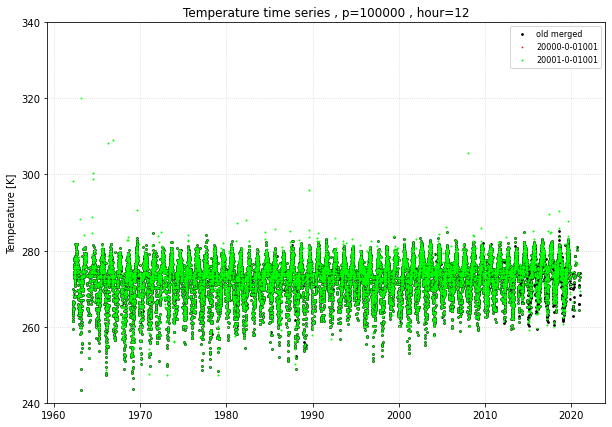

0


In [26]:
a = plot_series_old_new(df_old, df_s1, df_s2)

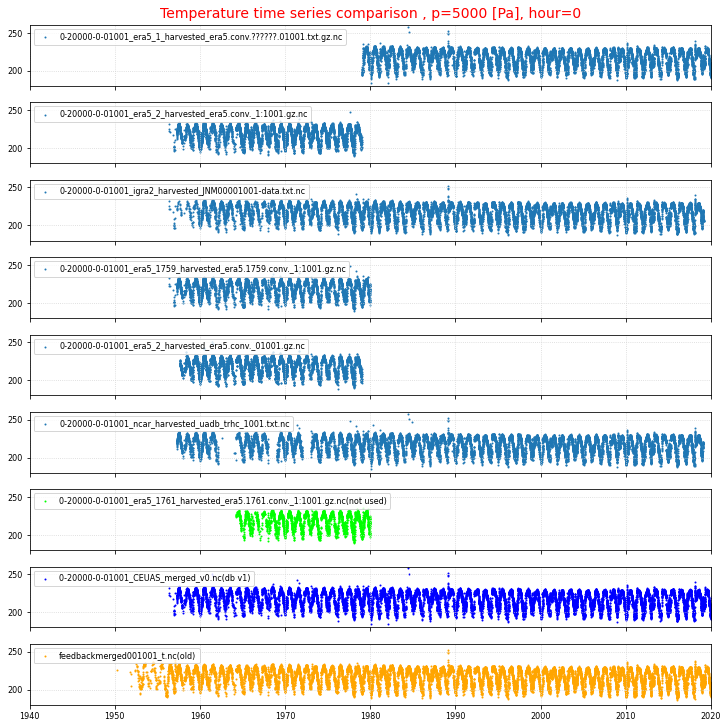

0


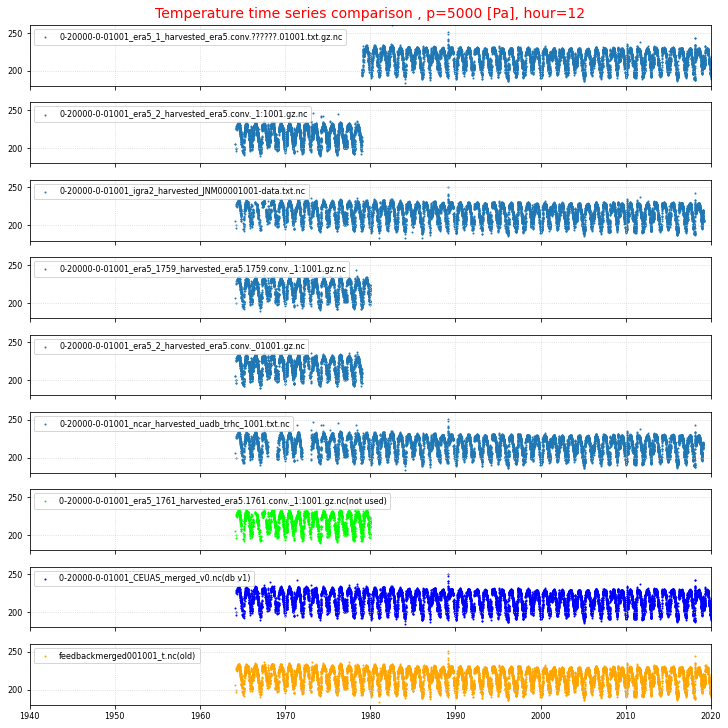

0


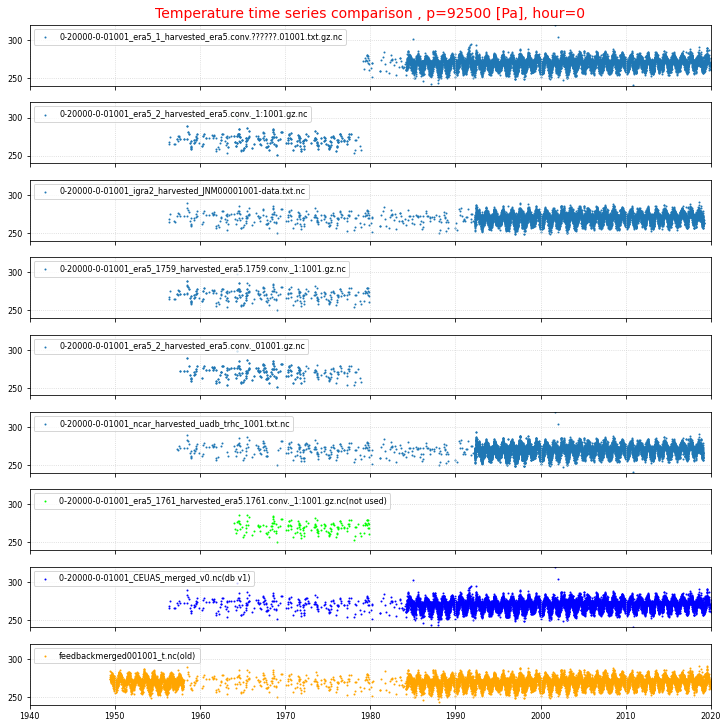

0


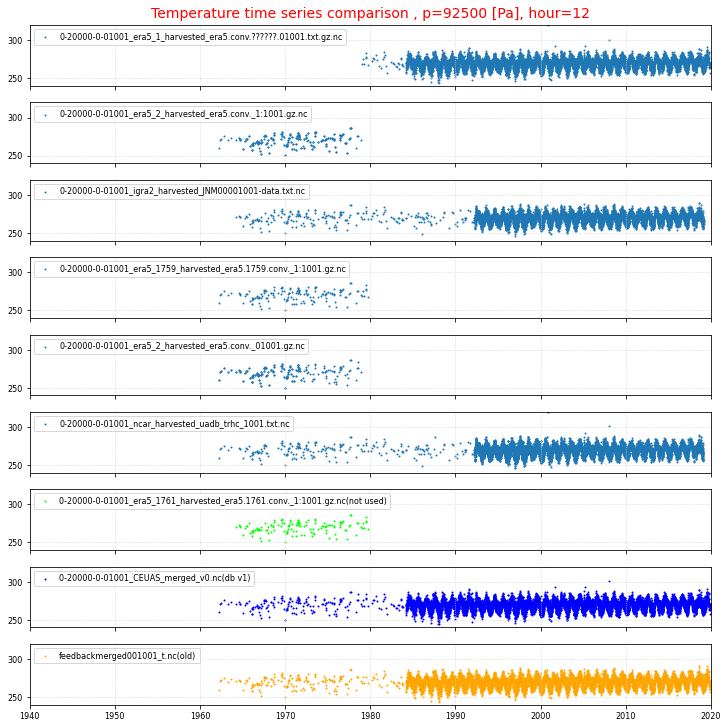

0


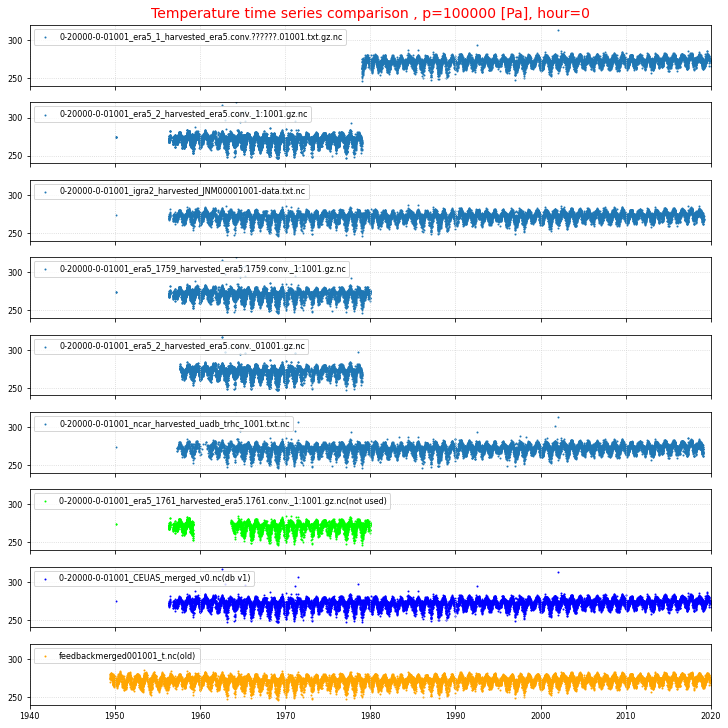

0


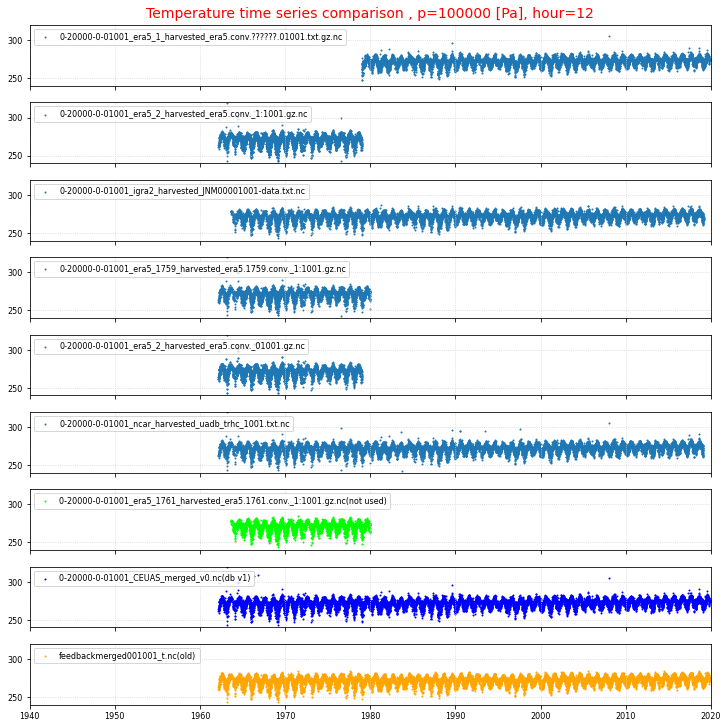

0


In [27]:
a = plot_new_comparison(files_list, dirs )